
<h1 style = "font-size : 36px">Phishing Detection in URLs <h1>


In [73]:
# import necessary libraries for the project which will also use pytorch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1234)

In [2]:
df = pd.read_csv('../dataset/phishing_site_urls.csv')
df.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


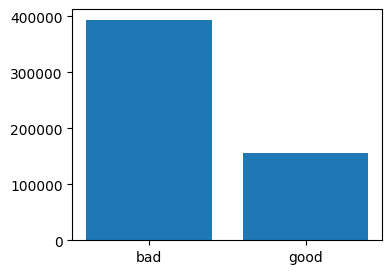

In [3]:
# plot to see the distribution of the data
plt.figure(figsize=(4, 3))
plt.bar(df['Label'].unique(), df['Label'].value_counts())
plt.show()


<h1> Feature extraction </h1>

In [4]:
# replace bad good with encoded values
df['Label'] = df['Label'].replace({'bad': 1, 'good': 0})
df.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,1
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,1
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,1
3,mail.printakid.com/www.online.americanexpress....,1
4,thewhiskeydregs.com/wp-content/themes/widescre...,1


In [5]:
text = " ".join(df['URL'].values.tolist())
text[:1000]

'nobell.it/70ffb52d079109dca5664cce6f317373782/login.SkyPe.com/en/cgi-bin/verification/login/70ffb52d079109dca5664cce6f317373/index.php?cmd=_profile-ach&outdated_page_tmpl=p/gen/failed-to-load&nav=0.5.1&login_access=1322408526 www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrcmd=_home-customer&nav=1/loading.php serviciosbys.com/paypal.cgi.bin.get-into.herf.secure.dispatch35463256rzr321654641dsf654321874/href/href/href/secure/center/update/limit/seccure/4d7a1ff5c55825a2e632a679c2fd5353/ mail.printakid.com/www.online.americanexpress.com/index.html thewhiskeydregs.com/wp-content/themes/widescreen/includes/temp/promocoessmiles/?84784787824HDJNDJDSJSHD//2724782784/ smilesvoegol.servebbs.org/voegol.php premierpaymentprocessing.com/includes/boleto-2via-07-2012.php myxxxcollection.com/v1/js/jih321/bpd.com.do/do/l.popular.php super1000.info/docs horizonsgallery.com/js/bin/ssl1/_id/www.paypal.com/fr/cgi-bin/webscr/cmd=_registration-run/login.php?cmd=_login-run&amp;dispatch=1471c4bdb044ae2be9e2fc3ec5

In [6]:
char = sorted(list(set(text)))
vocab_size = len(char)
print('Vocabulary size:', vocab_size)

Vocabulary size: 287


In [7]:
# make a new column that has the count of '-' in the URL and name it sub_domain
df['sub_domain'] = df['URL'].apply(lambda x: x.count('.'))
df['length_url'] = df['URL'].apply(lambda x: len(x))
df['dash_symbol'] = df['URL'].apply(lambda x: x.count('-'))

In [8]:
df.head()

,URL,Label,sub_domain,length_url,dash_symbol
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,1,6,225,4
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,1,5,81,2
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,1,7,177,1
3,mail.printakid.com/www.online.americanexpress....,1,6,60,0
4,thewhiskeydregs.com/wp-content/themes/widescre...,1,1,116,1


<h2> Counting sensitive words </h2>

In [9]:
def get_words(url):
    words = []
    word = ""
    for ch in url:
        if (ch >= 'a' and ch <= 'z') or (ch >= 'A' and ch <= 'Z'):
            word += ch
        else:
            if word:
                words.append(word)
            word = ""
    return words


In [10]:
bad_words = get_words(df[df['Label'] == 1]['URL'].str.cat(sep=" "))
# create a dictionary of words and their frequency
word_freq = {}
for word in bad_words:
    if word in word_freq:
        word_freq[word] += 1
    else:
        word_freq[word] = 1
# sort the dictionary in descending order
word_freq = dict(sorted(word_freq.items(), key=lambda x: x[1], reverse=True))
sensitive_words = list(word_freq.keys())[:150]

In [11]:
good_url_words = get_words(df[df['Label'] == 0]['URL'].str.cat(sep=" "))
good_word_freq = {}
for word in good_url_words:
    if word in good_word_freq:
        good_word_freq[word] += 1
    else:
        good_word_freq[word] = 1
good_word_freq = dict(sorted(good_word_freq.items(), key=lambda x: x[1], reverse=True))
good_words = list(good_word_freq.keys())[:20]

In [12]:
# remove good words from sensitive words
good_words_map = {}
for word in good_words:
    good_words_map[word] = 1
sensitive_words = [word for word in sensitive_words if word not in good_words_map and len(word) > 1]

In [13]:
df['count_sensitive_words'] = df['URL'].apply(lambda x: len([w for w in get_words(x) if w in sensitive_words]))

<h1> Pytorch Model <h1>

In [14]:
from nltk.tokenize import RegexpTokenizer  
from nltk.stem.snowball import SnowballStemmer
import time 

In [15]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')
stemmer = SnowballStemmer("english")

In [16]:
print('Getting words tokenized ...')
t0= time.perf_counter()
df['text_tokenized'] = df.URL.map(lambda t: tokenizer.tokenize(t))
t1 = time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting words tokenized ...
Time taken 1.205102416999999 sec


In [17]:
print('Getting words stemmed ...')
t0= time.perf_counter()
df['text_stemmed'] = df['text_tokenized'].map(lambda l: [stemmer.stem(word) for word in l])
t1= time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting words stemmed ...
Time taken 23.011401415999998 sec


In [18]:
df.sample(5)

,URL,Label,sub_domain,length_url,dash_symbol,count_sensitive_words,text_tokenized,text_stemmed
109277,ubauto.com.br/phpt-file/ymmmm/yinput/id.php?l=...,1,3,92,2,3,"[ubauto, com, br, phpt, file, ymmmm, yinput, i...","[ubauto, com, br, phpt, file, ymmmm, yinput, i..."
88685,www.deakin.edu.au/~rodneyc/XLStats.htm,0,4,38,0,1,"[www, deakin, edu, au, rodneyc, XLStats, htm]","[www, deakin, edu, au, rodneyc, xlstat, htm]"
218311,music.yahoo.com/michel-rivard/albums/,0,2,37,1,0,"[music, yahoo, com, michel, rivard, albums]","[music, yahoo, com, michel, rivard, album]"
497720,valsystem.cl/v4db1wd,1,1,20,0,2,"[valsystem, cl, v, db, wd]","[valsystem, cl, v, db, wd]"
307627,coldwellbanker.com/real_estate/home_search/wa/...,0,1,56,0,1,"[coldwellbanker, com, real, estate, home, sear...","[coldwellbank, com, real, estat, home, search,..."


In [173]:
# Joining all the stemmmed words.
print('Get joiningwords ...')
t0= time.perf_counter()
df['text_sent'] = df['text_stemmed'].apply(lambda l: ' '.join([token for token in l if len(token) > 1]))
t1= time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Get joiningwords ...
Time taken 0.32970387499972276 sec


In [174]:
df.head()

,URL,Label,sub_domain,length_url,dash_symbol,count_sensitive_words,text_tokenized,text_stemmed,text_sent
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,1,6,225,4,7,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobel, it, ffb, d, dca, cce, f, login, skype,...",nobel it ffb dca cce login skype com en cgi bi...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,1,5,81,2,5,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin...",www dghjdgf com paypal co uk cycgi bin webscrc...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,1,7,177,1,9,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbi, com, paypal, cgi, bin, get, into...",serviciosbi com paypal cgi bin get into herf s...
3,mail.printakid.com/www.online.americanexpress....,1,6,60,0,1,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, onlin, americanexp...",mail printakid com www onlin americanexpress c...
4,thewhiskeydregs.com/wp-content/themes/widescre...,1,1,116,1,4,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydreg, com, wp, content, theme, wide...",thewhiskeydreg com wp content theme widescreen...


In [175]:
from transformers import BertTokenizer

In [176]:
tokenizer = BertTokenizer.from_pretrained('/Users/arpit/Downloads/python_nb/url_phishing_detection/tokenizer/arpit')

In [165]:
# create a new dataframe with the text_sent column and the label column named df_train
df_train = pd.DataFrame({'text': df['text_sent'], 'label': df['Label']})

In [166]:
df_train.head()

,text,label
0,nobel ffb dca cce login skype com cgi bin veri...,1
1,www dghjdgf com paypal cycgi bin webscrcmd hom...,1
2,serviciosbi com paypal cgi bin get into herf s...,1
3,mail printakid com www onlin americanexpress c...,1
4,thewhiskeydreg com content theme widescreen in...,1


In [177]:
def encode(text):
    encoded_text = tokenizer.encode(text, add_special_tokens=True)
    sequence = torch.tensor(encoded_text).float()
    return sequence

In [179]:
df_train['text'] = df_train['text'].apply(lambda x: encode(x))

In [180]:
# calculate the mean length of the sequence
mean_length = df_train['text'].apply(lambda x: len(x)).mean()
print('Mean length of the sequence:', mean_length)

Mean length of the sequence: 20.060042304849766


In [189]:
# calculate the percentage of sequences that are less than 512
print('Percentage of sequences less than 512 in length:', len(df_train[df_train['text'].apply(lambda x: len(x) <= 64)]) / len(df_train))


Percentage of sequences less than 512 in length: 0.9872557550250661


In [190]:
text_list = df_train['text'].tolist()
# Pad the text tensors in the list
for i,text in enumerate(text_list):
    text_list[i]/=1000
    if(len(text) > 64):
        text_list[i] = text_list[i][:64]


padded_text = pad_sequence(text_list, batch_first=True)

In [191]:
n = len(padded_text)
train_text = padded_text[:int(0.8 * n)]
val_text = padded_text[int(0.8 * n):]
train_target = df_train['label'].tolist()[:int(0.8 * n)]
val_target = df_train['label'].tolist()[int(0.8 * n):]

In [192]:
train_text[1].shape

torch.Size([64])

In [193]:
# Define a PyTorch dataset
class MyDatasetTrain(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data[index]
        target = self.targets[index]
        text , target = torch.tensor(text), torch.tensor(target)
        text , target = text.to(device), target.to(device)
        return text, target

In [194]:
# Define a PyTorch dataset
class MyDatasetVal(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data[index]
        target = self.targets[index]
        text , target = torch.tensor(text), torch.tensor(target)
        text , target = text.to(device), target.to(device)
        return text, target

In [195]:
train_data = MyDatasetTrain(train_text, train_target)
val_data = MyDatasetVal(val_text, val_target)

In [196]:
# Define a PyTorch DataLoader
batch_size = 128
train_dataloader = DataLoader(train_data, batch_size=batch_size)
val_dataloader = DataLoader(val_data, batch_size=batch_size)

In [356]:
class MyModelForText(torch.nn.Module):
    def __init__(self, weight_decay=0.2):
        super(MyModelForText, self).__init__()
        self.input_dim = 64
        self.hidden_dim = 4
        self.output_dim = 1
        self.num_layers = 2
        self.dropout = 0.3
        self.norm_layer = nn.LayerNorm(self.input_dim)
        self.norm_layer_2 = nn.LayerNorm(self.hidden_dim)
        self.input_layer = nn.Linear(self.input_dim, self.hidden_dim)
        # self.hidden_layer = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.output_layer = nn.Linear(self.hidden_dim, self.output_dim)
        self.weight_decay = weight_decay

    def forward(self, x, target=None):
        x = x.to(self.input_layer.weight.dtype)
        x = self.input_layer(self.norm_layer(x))
        x = F.dropout(x, p=self.dropout)
        x = torch.tanh(x)
        # x = self.hidden_layer(x)
        # x = torch.tanh(x)
        # x = F.dropout(x, p=self.dropout)
        x = self.output_layer(x)
        logits = torch.sigmoid(x)

        if target is None:
            loss = None
        else:
            weight_decay_loss = 0.0
            for param in self.parameters():
                weight_decay_loss += self.weight_decay * torch.norm(param, 2)
            loss = F.binary_cross_entropy(logits, target.view(-1, 1).float()) + weight_decay_loss

        return logits, loss
# class MyModelForText(nn.Module):
#     def __init__(self):
#         super(MyModelForText, self).__init__()
#         self.input_dim = 512
#         self.hidden_dim = 1024
#         self.output_dim = 1
#         self.num_layers = 2
#         self.dropout = 0.2
#         self.norm_layer = nn.LayerNorm(self.input_dim)
        
#         # Add LSTM layers
#         self.lstm = nn.LSTM(input_size=self.input_dim, hidden_size=self.hidden_dim, 
#                             num_layers=self.num_layers, batch_first=True, 
#                             dropout=self.dropout, bidirectional=False)
        
#         self.output_layer = nn.Linear(self.hidden_dim, 1000)

#     def forward(self, x, target=None):
#         x = x.to(self.lstm.weight_ih_l0.dtype)
        
#         # Pass input through LSTM layers
#         lstm_out, _ = self.lstm(self.norm_layer(x))
        
#         # Extract output from the final timestep
#         lstm_out = torch.squeeze(lstm_out[:, -1])
        
#         # Pass through output layer
#         logits = self.output_layer(lstm_out)
#         logits = torch.sigmoid(logits)
        
#         if target is None:
#             loss = None
#         else:
#             loss = F.binary_cross_entropy(logits, target.view(-1, 1).float())

#         return logits, loss


In [357]:
model = MyModelForText()
model = model.to(device)
# calc parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)

In [358]:
def get_batch(split):
    if split == 'train' :
        return next(iter(train_dataloader))
    else:
        return next(iter(val_dataloader))

In [359]:
# Iterate over the validation data in batches and evaluate the model
eval_iters = 100
@torch.no_grad()
def estimate_loss(split):
    model.eval()
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
        text, target = get_batch(split)
        output = model(text, target)
        logits, loss = output
        losses[k] = loss.item()
    model.train()
    return losses.mean()

In [360]:
train_loss = []
val_loss = []

In [361]:
# Iterate over the data in batches and feed it to the network
for i in range(5000):
    text , target = get_batch('train')
    logits, loss = model(text, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # if(i%100 == 0):
    #     print(loss)
    if i % 100 == 0:
        tl = estimate_loss('train')
        vl = estimate_loss('val')
        train_loss.append(tl)
        val_loss.append(vl)
        print(f"Iteration: {i} Loss: {tl:.4f} Validation Loss: {vl:.4f}")
    
    

/var/folders/rv/_5tfd6f94s7gykpts92y23g80000gn/T/ipykernel_27323/309159916.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text , target = torch.tensor(text), torch.tensor(target)


Iteration: 0 Loss: 2.9097 Validation Loss: 3.3556
Iteration: 100 Loss: 1.9802 Validation Loss: 3.2257
Iteration: 200 Loss: 1.4343 Validation Loss: 2.6541
Iteration: 300 Loss: 0.7429 Validation Loss: 1.7447
Iteration: 400 Loss: 0.5034 Validation Loss: 1.7438
Iteration: 500 Loss: 0.5018 Validation Loss: 1.8367
Iteration: 600 Loss: 0.5021 Validation Loss: 1.8724
Iteration: 700 Loss: 0.5014 Validation Loss: 1.8835
Iteration: 800 Loss: 0.5016 Validation Loss: 1.8869
Iteration: 900 Loss: 0.5015 Validation Loss: 1.8876
Iteration: 1000 Loss: 0.5013 Validation Loss: 1.8876
Iteration: 1100 Loss: 0.5017 Validation Loss: 1.8880
Iteration: 1200 Loss: 0.5015 Validation Loss: 1.8878
Iteration: 1300 Loss: 0.5014 Validation Loss: 1.8877
Iteration: 1400 Loss: 0.5017 Validation Loss: 1.8880
Iteration: 1500 Loss: 0.5015 Validation Loss: 1.8878
Iteration: 1600 Loss: 0.5015 Validation Loss: 1.8878
Iteration: 1700 Loss: 0.5015 Validation Loss: 1.8878
Iteration: 1800 Loss: 0.5017 Validation Loss: 1.8880
Itera

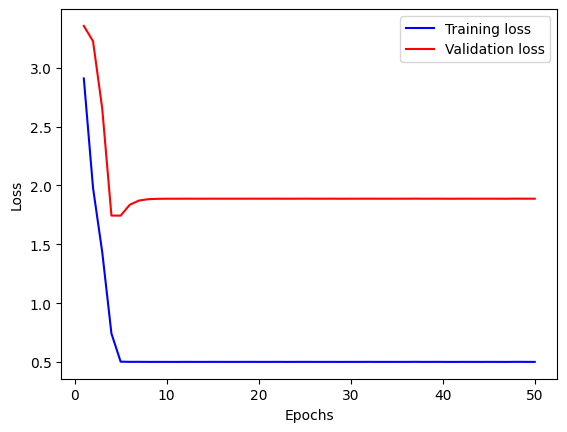

In [362]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(train_loss)+1))

# plot training loss in blue and validation loss in red
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

# set axis labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()